# Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

# Описание данных
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import math
import matplotlib.pyplot as plt

# Шаг 1. Открытие файла с данными и изучение общей информации


In [48]:
try:
    games = pd.read_csv('games.csv')
    games
except:
    games = pd.read_csv('/datasets/games.csv')
    games

In [49]:
games.sample(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
9567,Rock Band Track Pack Volume 2,PS3,2008.0,Misc,0.11,0.0,0.00,0.01,NaN,tbd,T
3222,Virtua Cop,SAT,1995.0,Shooter,0.00,0.0,0.62,0.00,NaN,NaN,NaN
9576,Sengoku Basara 3 Utage,Wii,2011.0,Action,0.00,0.0,0.13,0.00,NaN,NaN,NaN
10694,Initial D: Street Stage,PSP,2006.0,Racing,0.00,0.0,0.10,0.00,NaN,NaN,NaN
11706,Majin Tensei,SNES,1994.0,Role-Playing,0.00,0.0,0.08,0.00,NaN,NaN,NaN


# Шаг 2. Подготовьте данные

In [50]:
#меняю названия столбцов
games.rename(columns={'Year_of_Release':'year', 'NA_sales':'na', 'JP_sales':'jp', 'EU_sales':'eu', 'Other_sales':'other'}, inplace=True)

In [51]:
# 
games.columns = games.columns.str.lower()

In [52]:
games.info()
#нужно поменять типы данных:year, user_score, raiting

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name            16713 non-null object
platform        16715 non-null object
year            16446 non-null float64
genre           16713 non-null object
na              16715 non-null float64
eu              16715 non-null float64
jp              16715 non-null float64
other           16715 non-null float64
critic_score    8137 non-null float64
user_score      10014 non-null object
rating          9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [53]:
games['year'] = games['year'].fillna(0)
# заполняем пропущенные значения в столбце 'year' нулями
#games['year'] = games['year'].astype(int)
games[['year', 'critic_score']] = games[['year', 'critic_score']].astype('Int64')
#games['user_score'] = games['user_score'].astype('Int64')
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

**Мы обнаружили аббревиатуру 'tbd', что означает рейтинг не определен. Можно просто заменить на nan**

In [54]:
games.loc[games['user_score'] == 'tbd', 'user_score'] = np.nan
games['user_score'].unique()
games['user_score'] = games['user_score'].astype('float')

In [55]:
games[games['name'].isnull()]

,name,platform,year,genre,na,eu,jp,other,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [56]:
games = games.dropna(subset = ['name'])

In [57]:
games.isnull().sum(axis=0).sort_values()

name               0
platform           0
year               0
genre              0
na                 0
eu                 0
jp                 0
other              0
rating          6764
critic_score    8576
user_score      9123
dtype: int64

In [58]:
games['critic_score'].unique()

<IntegerArray>
[ 76, NaN,  82,  80,  89,  58,  87,  91,  61,  97,  95,  77,  88,  83,  94,
  93,  85,  86,  98,  96,  90,  84,  73,  74,  78,  92,  71,  72,  68,  62,
  49,  67,  81,  66,  56,  79,  70,  59,  64,  75,  60,  63,  69,  50,  25,
  42,  44,  55,  48,  57,  29,  47,  65,  54,  20,  53,  37,  38,  33,  52,
  30,  32,  43,  45,  51,  40,  46,  39,  34,  35,  41,  36,  28,  31,  27,
  26,  19,  23,  24,  21,  17,  22,  13]
Length: 83, dtype: Int64

In [59]:
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [60]:
# считаем суммы всех продаж
games['total_sales'] = games['na'] + games['eu'] + games['jp'] + games['other']
games['total_sales']


0        82.54
1        40.24
2        35.52
3        32.77
4        31.38
         ...  
16710     0.01
16711     0.01
16712     0.01
16713     0.01
16714     0.01
Name: total_sales, Length: 16713, dtype: float64

### Вывод: получилось много пропусков в столбцах rating, critic_score, user_score. С ними мы пока ничего не можем сделать, потому что игры могут быть новыми, которые не успели оценить критики и пользователи. Эти данные нельзя просто так отбросить, потому что ещё могут пригодиться для дальнейшего анализа.


# Шаг 3. Проведите исследовательский анализ данных

In [61]:
games['year'].max()

2016

In [62]:
games[games['year'] > 1900]['year'].min()

1980

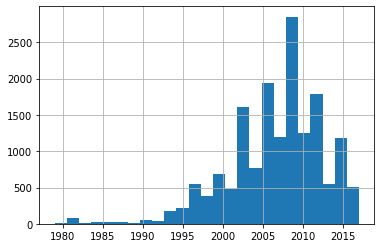

In [63]:
games['year'].hist(bins = 25, range=(1979, 2017))

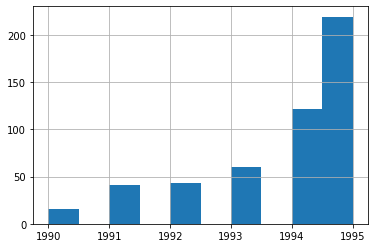

In [64]:
games['year'].hist(bins = 10, range=(1990, 1995))

Игры начали выпускаться с 1980. Данные до 1994 года не так сильно важны

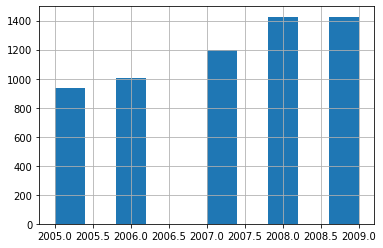

In [65]:
games['year'].hist(bins = 10, range=(2005, 2009))

Пожалуй самый важный период с 2005 по 2009 год. В этот промежуток времени выпускалось наибольшее количество игр

In [66]:
#top10_platforms = games['platform'].value_counts().head(10)
platforms_ascending = games.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').sort_values(by = 'total_sales', ascending = False)
#top10_platforms = platforms_ascending.head(10).reset_index()
top10_platforms = platforms_ascending.reset_index()
iloc_top10_platforms = top10_platforms.iloc[0:10]
#top10_platforms_dict =top10_platforms.unique()
top10_platforms = iloc_top10_platforms['platform'].unique()
platforms_ascending

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


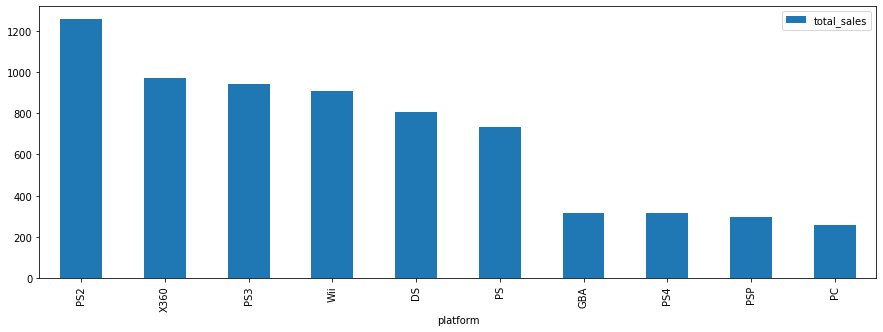

In [67]:
iloc_top10_platforms.plot(x="platform", y="total_sales", kind='bar', figsize=(15,5))

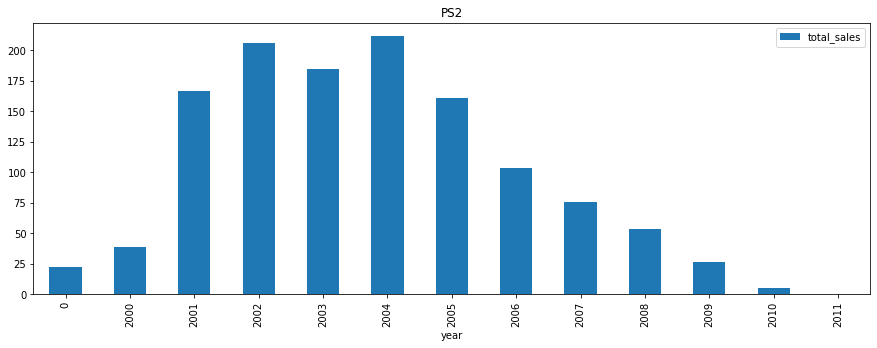

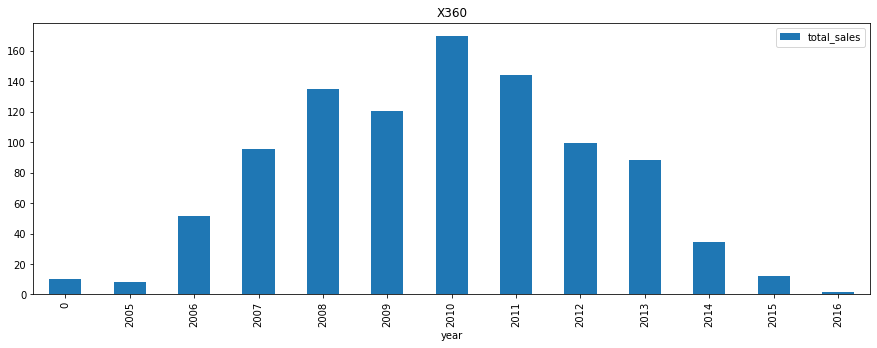

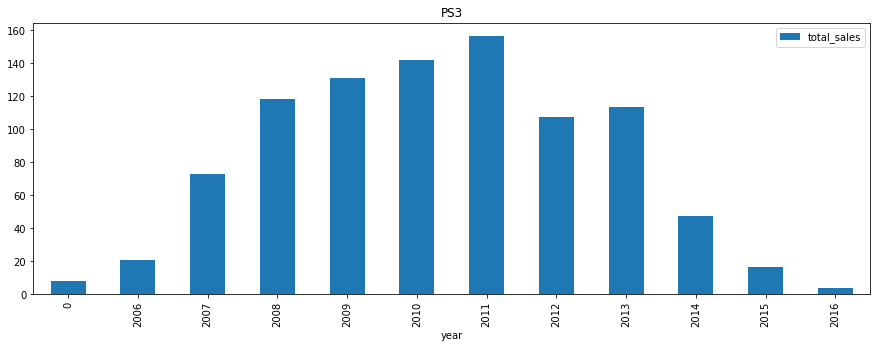

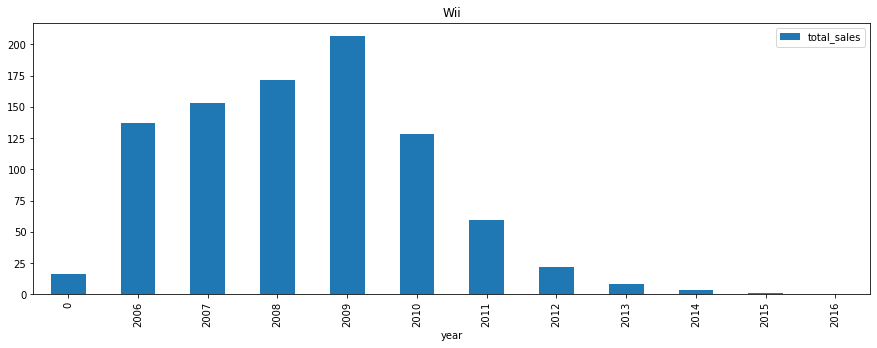

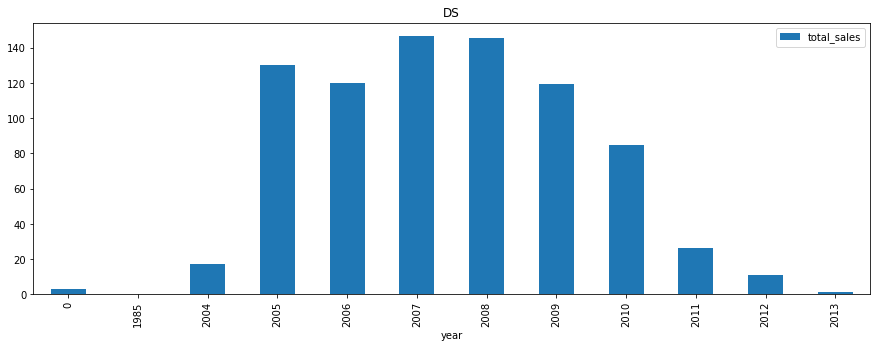

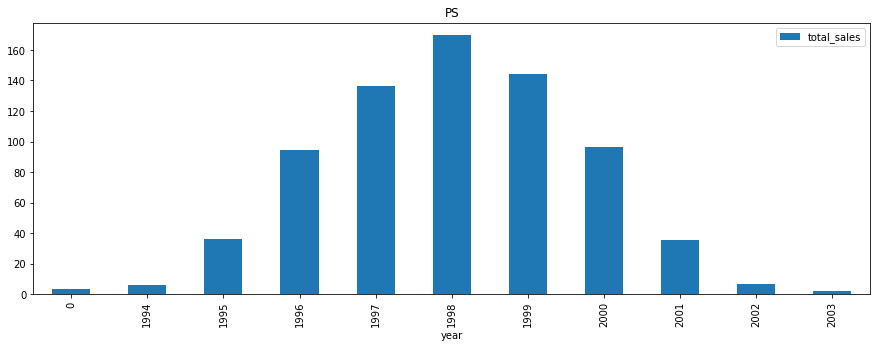

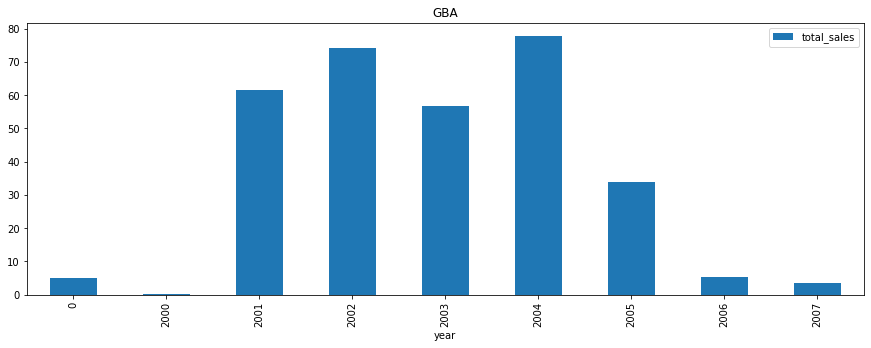

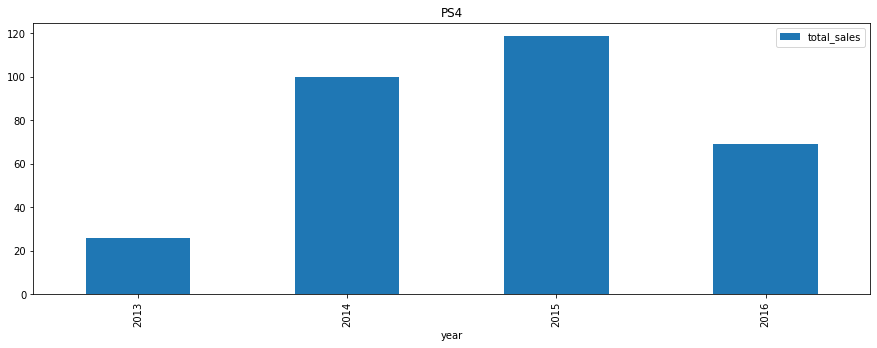

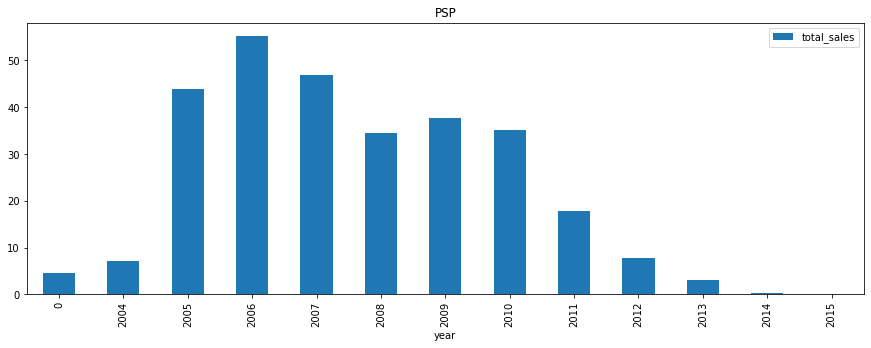

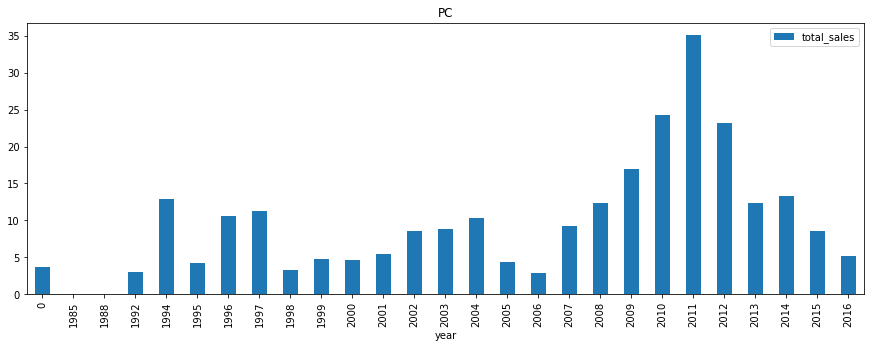

In [68]:
for platform in top10_platforms:
    games[games['platform'] == platform].pivot_table(index = 'year', values = 'total_sales', aggfunc = 'sum').plot(kind = 'bar', figsize=(15,5))
    plt.title(platform)

Вывод: В среднем платформа существует 10 лет. Большинство платформ появляется в начале 2000-x, особенно в 2006 году

Чем больше выборка, тем точнее результат, но прогноз нам нужно сделать на 2017 год. Соотвественно чем дальше мы отклоняемся, тем сильнее прогноз может быть искажет. По моему мнению актуальный период 2006 - 2016.

In [69]:
actual_data = games.query('year >= 2006') #возьмем все данные после 2006 года
#sns.catplot(x='platform')

Графики по количеству выпущенных игр за актуальный период на разных платформах

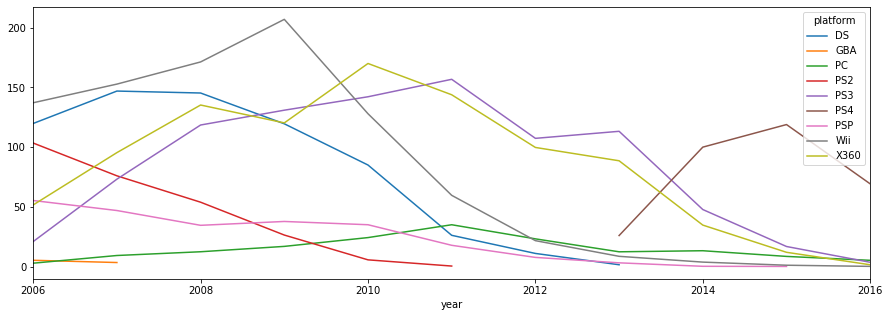

In [70]:
actual_data.query('platform in @top10_platforms').pivot_table(index='year', columns = 'platform', values='total_sales', aggfunc='sum').plot(figsize=(15, 5))

Все игры на платформах идут на снижение по продажам. Среди них игры  на PS4 продаются гораздо чаще, скорее всего, потому что консоль появилась не так давно. PS4 является потенциально прибыльной, также PC, потому что показывает хоть небольшие, но стабильные продажи. падает сильнее всего спрос на консоли: X360, PS3. На остальные консоли уже давно упал спрос, либо вообще не продаются.

Итого потенциально прибыльные:
* PC, PS4, XOne

Потенциально не будут продаваться:
* X360, PS3

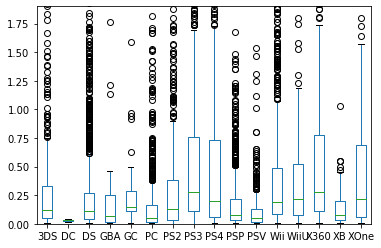

In [71]:
actual_data.pivot_table(index = 'name', columns = 'platform', values = 'total_sales', aggfunc = 'sum').plot(kind='box', ylim=(0,1.9))

На графике мы видем, что мы не учли консоль только набирающую популярность - XOne. На нее было выпущено не так много игр, поэтому мы ее не включили в предыдущий график, но игры этой консоли очень хорошо продаются, потому что медианные значения PS4 и XOne почти совпадают. Добавим XOne в список потенциально прибыльных.

**Так как 2016 год ещё не закончился, то у нас есть много пропусков в данных, которые мы хотим коллерировать, поэтому лучше взять одну из популярных консоль, у которой нет данных в 2016. Это PSP**

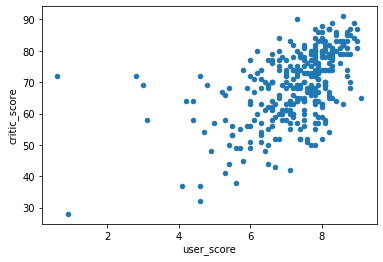

In [72]:
PSP = actual_data.query('platform == "PSP"')
PSP.plot(x='user_score', y='critic_score', kind='scatter')

In [73]:
PSP_cor = PSP[['critic_score','user_score', 'total_sales']]
PSP_cor.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.530828,0.315340
user_score,0.530828,1.000000,0.241651
total_sales,0.315340,0.241651,1.000000


По диаграмме видно, что в целом оценки критиков с оценками пользователей совпадают.
По таблице можно сказать, что игровая аудитория прислушивается не только к критикам, но и к игрокам. PSP не самый удачный пример, потому что количество продаж не сильно зависит от оценок

In [74]:
XOne = actual_data.query('platform == "XOne"')
PS4 = actual_data.query('platform == "PS4"')
PC = actual_data.query('platform == "PC"')

In [75]:
PC_cor = PC[['critic_score','user_score', 'total_sales']]
PC_cor.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.521036,0.286919
user_score,0.521036,1.000000,-0.020556
total_sales,0.286919,-0.020556,1.000000


In [76]:
PS4_cor = PS4[['critic_score','user_score', 'total_sales']]
PS4_cor.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.557654,0.406568
user_score,0.557654,1.000000,-0.031957
total_sales,0.406568,-0.031957,1.000000


In [77]:
XOne_cor = XOne[['critic_score','user_score', 'total_sales']]
XOne_cor.corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.472462,0.416998
user_score,0.472462,1.000000,-0.068925
total_sales,0.416998,-0.068925,1.000000


По платформам PC, PS4, XOne однозначно можно сказать, что оценки критиков влияют на количество продаж, а оценки пользователей не принимают во внимание.

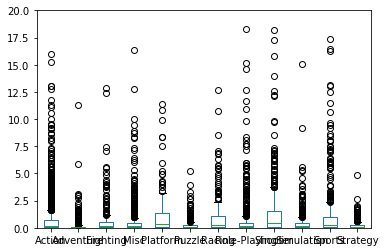

In [78]:
actual_data.pivot_table(index = 'name', columns = 'genre', values = 'total_sales', aggfunc = 'sum').plot(kind='box', ylim=(0,20))

### Смотрим самые популярные игровые жанры по продажам.

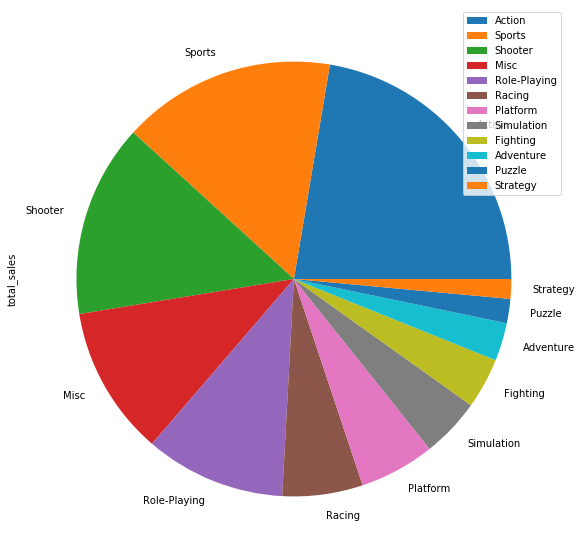

In [79]:
actual_data.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'sum').sort_values(ascending=False, by = 'total_sales').plot(kind='pie', figsize=(10,10), y= 'total_sales')

In [80]:
actual_data.pivot_table(index = 'genre', values = 'total_sales', aggfunc = 'sum').sort_values(ascending=False, by = 'total_sales')


,total_sales
genre,
Action,1116.65
Sports,793.85
Shooter,717.04
Misc,554.86
Role-Playing,522.40
Racing,299.00
Platform,279.74
Simulation,220.65
Fighting,188.42


ВЫВОД:

Самые прибыльные жанры - Action, Sports, Shooter

Наименее прибыльные жанры - Strategy, Puzzle 

# Шаг 4. Составьте портрет пользователя каждого региона

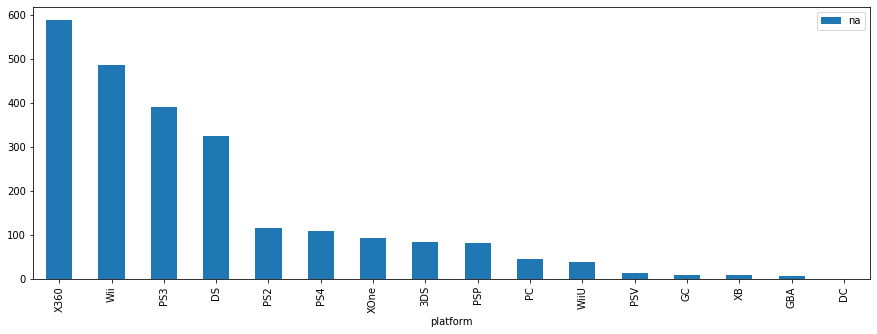

In [81]:
actual_data.pivot_table(index = 'platform', values = 'na', aggfunc = 'sum').sort_values(ascending=False, by = 'na').plot(kind = 'bar', figsize=(15,5))

Пользователи Северной Америки больше всего предпочитают Xbox360, потому что консоль американская. Платформы Wii, PS3, DS - пользуются также значительной популярностью, но они японские. В сумме продаж преобладают игры на японских консолях.

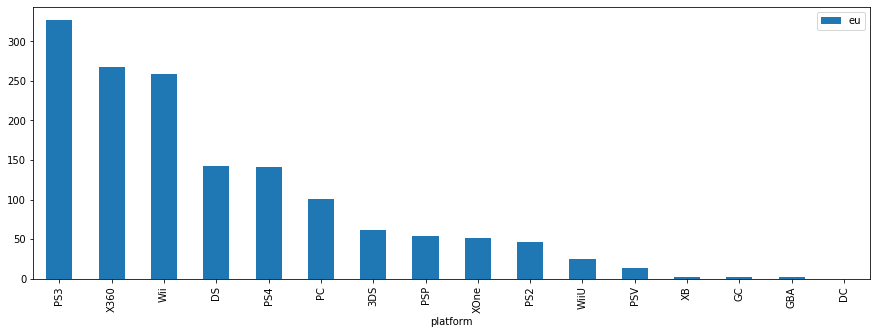

In [82]:
actual_data.pivot_table(index = 'platform', values = 'eu', aggfunc = 'sum').sort_values(ascending=False, by = 'eu').plot(kind = 'bar', figsize=(15,5))

У пользователей Европы популярны и японские платформы, и американская консоль Xbox360. В целом запросы такие же как у пользователей из Северной Америки.

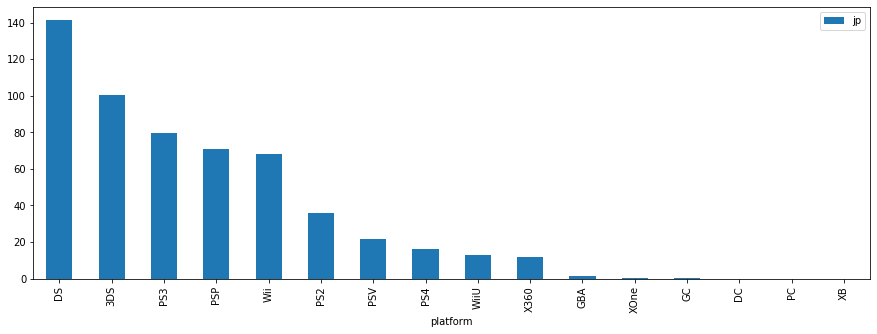

In [83]:
actual_data.pivot_table(index = 'platform', values = 'jp', aggfunc = 'sum').sort_values(ascending=False, by = 'jp').plot(kind = 'bar', figsize=(15,5))

Подавляющее большинство японских пользователей играют в японские платформы, что неудивительно из-за большого разнообразия платформ

### Можно сделать общий вывод, что пользователи предпочитают играть на платформах своей же страны

In [84]:
actual_data.pivot_table(index = 'genre', values = 'na', aggfunc = 'sum').sort_values(ascending=False, by = 'na')


,na
genre,
Action,530.44
Sports,396.64
Shooter,373.13
Misc,285.06
Role-Playing,199.63
Platform,134.25
Racing,132.93
Simulation,107.79
Fighting,94.31


In [85]:
actual_data.pivot_table(index = 'genre', values = 'eu', aggfunc = 'sum').sort_values(ascending=False, by = 'eu')


,eu
genre,
Action,350.70
Sports,251.55
Shooter,238.89
Misc,146.88
Racing,113.39
Role-Playing,110.62
Platform,81.62
Simulation,69.74
Fighting,42.63


In [86]:
actual_data.pivot_table(index = 'genre', values = 'jp', aggfunc = 'sum').sort_values(ascending=False, by = 'jp')

,jp
genre,
Role-Playing,170.38
Action,102.07
Misc,64.53
Sports,48.97
Platform,35.20
Adventure,29.53
Fighting,28.61
Simulation,23.31
Shooter,19.35


ВЫВОД: Пользователи Европы и Северной Америки играют в целом в одни и те же консоли и игровая индустрия больше развита в домашнем уюте, поэтому популярны жанры - Action, Sports, Shooter. В японии преобладают пользователи с портативными консолями, в которые можно играть не только дома, поэтому они предпочитают жанр - Role-Playing и редко играют в игры с жанром - shooter.

In [87]:
actual_data['region'] = actual_data['eu'] + actual_data['jp'] + actual_data['na']
actual_data['region']

C:\Users\list2\anaconda3.0\envs\Praktikum\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0        74.09
2        32.23
3        29.82
6        26.92
7        26.07
         ...  
16709     0.00
16710     0.01
16711     0.01
16712     0.01
16714     0.01
Name: region, Length: 10333, dtype: float64

In [88]:
ESRB = actual_data.pivot_table(index = 'rating', values = ['eu','jp','na'], aggfunc = 'sum')
ESRB

,eu,jp,na
rating,,,
E,461.09,120.36,796.98
E10+,173.35,36.57,315.40
EC,0.00,0.00,1.32
M,398.90,43.79,574.33
RP,0.03,0.00,0.00
T,235.44,83.90,424.14


Да, рейтинг влияет на продажи в отдельных регионах. Так, например, игры с рейтингом EC продавались в основном только в Северной Америке

# Шаг 5. Проверьте гипотезы

1 гипотеза:
* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

2 гипотеза:

* Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [89]:
XOne = actual_data[(actual_data['platform'] == 'XOne') &  (actual_data['user_score'] > 0)]['user_score']#.mean().round()
PC = actual_data[(actual_data['platform'] == 'PC') &  (actual_data['user_score'] > 0)]['user_score']#.mean().round()
print('Средний пользовательский рейтинг платформы Xbox One:', XOne.mean())
print('Средний пользовательский рейтинг платформы PC', PC.mean())

Средний пользовательский рейтинг платформы Xbox One: 6.521428571428572
Средний пользовательский рейтинг платформы PC 6.830081300813008


H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

H1: Средние пользовательские рейтинги платформ Xbox One и PC разные

In [90]:
#проверяем первую гипотезу

alpha = .05

results = st.ttest_ind(XOne, PC, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.01014021353497224
Отвергаем нулевую гипотезу


#### Вывод: 1 гипотеза не подтвердилась. Средние пользовательские рейтинги платформ Xbox One и PC разные

H0: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые

H1: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

In [91]:
Action = actual_data[(actual_data['genre'] == 'Action') &  (actual_data['user_score'] > 0)]['user_score']#.mean().round()
Sports = actual_data[(actual_data['genre'] == 'Sports') &  (actual_data['user_score'] > 0)]['user_score']#.mean().round()
print('Средний пользовательский рейтинг жанра Action:', Action.mean())
print('Средний пользовательский рейтинг жанра Sports', Sports.mean())

Средний пользовательский рейтинг жанра Action: 6.878625377643504
Средний пользовательский рейтинг жанра Sports 6.416420118343195


In [92]:
#проверяем вторую гипотезу

alpha = .05

results = st.ttest_ind(Action, Sports, equal_var=False)

print('p-значение:', results.pvalue)


if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 5.319061853268226e-10
Отвергаем нулевую гипотезу


#### Вывод: 2 гипотеза подтвердилась. Средние пользовательские рейтинги жанров Action и Sports разные


# Шаг 6. Напишите общий вывод

Критерии определяющие успешность игры:
1. Регион
* Рейтинг ассоциации, определяющей возрастной рейтинг компьютерных игр
* Платформа, которая наиболее распространена в данном регионе
* Жанр
2. Рейтинг критиков (влияет на количество продаж во всех регионах)



Игры, которые будут продаваться в __Северной Америке__ лучше всего:  
ESRB: E, M, T  
Платформ(в порядке убывания): Xbox360, Wii, PS3, DS  
Жанры: Action, Sports, Shooter, Misc, Role-Playing  



Игры, которые будут продаваться в __Европе__ лучше всего:  
ESRB: E, M, T  
Платформы: в PS3, Xbox360, Wii, DS   
Жанры: Action, Sports, Shooter, Misc, Racing  



Игры, которые будут продаваться в __Японии__ лучше всего:  
ESRB: E, T, M  
Платформы: DS, 3DS, PS3, PSP, Wii  
Жанры: Role-Playing, Action, Misc, Sports, Platform  

***Рейтинги, жанры, платформы указаны в порядке убывания***